In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Import SMOTE for oversampling
from imblearn.over_sampling import SMOTE

In [2]:
# 1. Load dataset into df
df = pd.read_csv("./data/brain_stroke.csv")

In [3]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


### Encoding Categorical Features

In [31]:
df_encoded = df.copy(deep=True)
df_encoded['gender'] = [0 if i != 'Female' else 1 for i in df['gender']]
df_encoded['ever_married'] = [0 if i != 'Yes' else 1 for i in df['ever_married']]
df_encoded = pd.get_dummies(df_encoded, columns=['work_type', 'Residence_type', 'smoking_status'])
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          4981 non-null   int64  
 1   age                             4981 non-null   float64
 2   hypertension                    4981 non-null   int64  
 3   heart_disease                   4981 non-null   int64  
 4   ever_married                    4981 non-null   int64  
 5   avg_glucose_level               4981 non-null   float64
 6   bmi                             4981 non-null   float64
 7   stroke                          4981 non-null   int64  
 8   work_type_Govt_job              4981 non-null   bool   
 9   work_type_Private               4981 non-null   bool   
 10  work_type_Self-employed         4981 non-null   bool   
 11  work_type_children              4981 non-null   bool   
 12  Residence_type_Rural            49

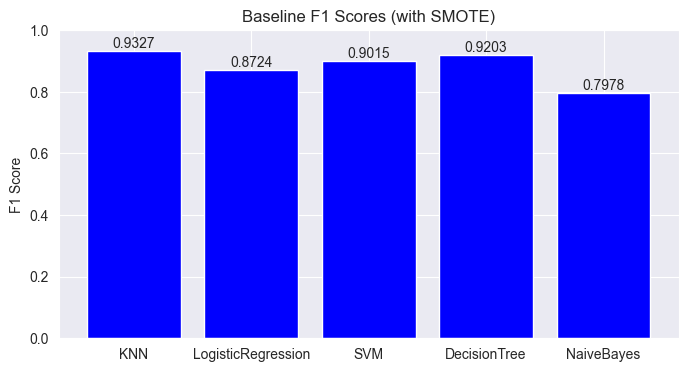

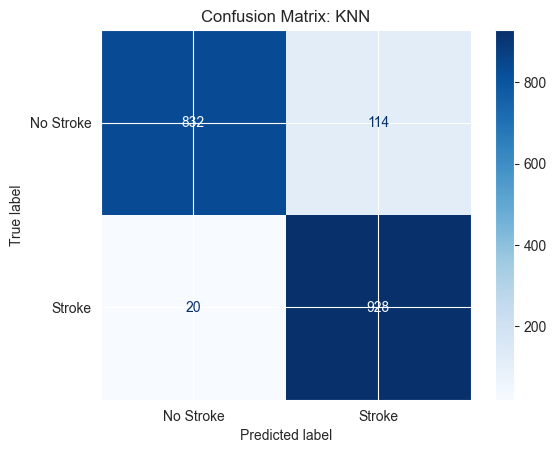

F1 Scores: {'KNN': 0.9326633165829146, 'LogisticRegression': 0.8724461623412479, 'SVM': 0.9015433741351783, 'DecisionTree': 0.9202518363064008, 'NaiveBayes': 0.797768479776848}
Best model based on F1 score: KNN


In [143]:
# 3. Separate features and target
X = df_encoded.drop("stroke", axis=1)
y = df_encoded["stroke"]

# 4. Scale numeric columns
numeric_cols = X.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# 5. Address class imbalance with SMOTE (oversampling the minority class)
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(X, y)

# 6. Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

# 7. Define models
#    We also add class_weight='balanced' where supported to further help with imbalance.
models = {
    "KNN": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "SVM": SVC(class_weight='balanced'),
    "DecisionTree": DecisionTreeClassifier(class_weight='balanced'),
    "NaiveBayes": GaussianNB()
}

# 8. Train each model on the resampled data and compute F1 scores
f1_scores = {}
for name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    f1_scores[name] = f1_score(y_test, y_pred)

# 9. Plot the F1 scores
plt.figure(figsize=(8, 4))
bars = plt.bar(f1_scores.keys(), f1_scores.values(), color='blue')
plt.title("Baseline F1 Scores (with SMOTE)")
plt.ylabel("F1 Score")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.4f}",
             ha='center', va='bottom')
plt.ylim([0, 1])
plt.show()

# 10. Confusion matrix for the best model
best_model_name = max(f1_scores, key=f1_scores.get)
best_model = models[best_model_name]
y_pred_best = best_model.predict(x_test)

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(cm, display_labels=["No Stroke", "Stroke"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix: {best_model_name}")
plt.show()

print("F1 Scores:", f1_scores)
print(f"Best model based on F1 score: {best_model_name}")

Selected features using L1 regularization: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Rural', 'Residence_type_Urban', 'smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']
F1 score with L1-selected features: 0.9521762493283181
Removing 'smoking_status_Unknown' with p-value 0.9988
Removing 'work_type_Govt_job' with p-value 1.0000
Removing 'Residence_type_Rural' with p-value 0.9992
Selected features using Backward Elimination: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 'bmi', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


/Users/rocker/PycharmProjects/ELG6131/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rocker/PycharmProjects/ELG6131/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rocker/PycharmProjects/ELG6131/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


F1 score with Backward Elimination-selected features: 0.92180217503884

Comparison of F1 scores:
L1 Regularization Feature Selection F1 score: 0.9521762493283181
Backward Elimination Feature Selection F1 score: 0.92180217503884


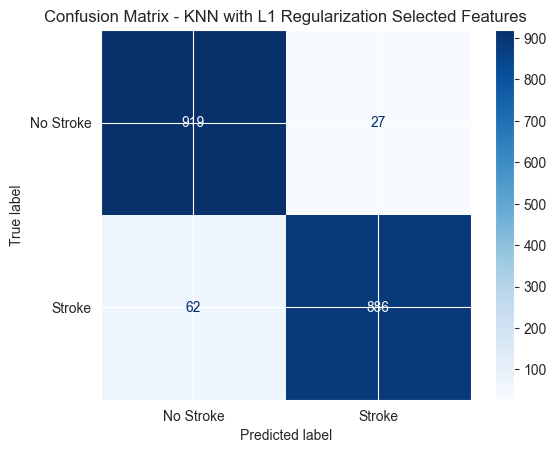

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# Statsmodels for backward elimination
import statsmodels.api as sm

# Separate features and target
X = df_encoded.drop("stroke", axis=1)
y = df_encoded["stroke"]

smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data (use stratification because stroke is imbalanced)
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

# Apply scaling to all numeric features (necessary for KNN)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Convert back to DataFrame to keep feature names
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x_train.columns, index=x_train.index)
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_test.columns, index=x_test.index)

# =======================
# 1. Feature Selection using L1 Regularization
# =======================
# Use logistic regression with L1 penalty as a feature selector.
l1_selector = SelectFromModel(
    LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)
)
l1_selector.fit(x_train_scaled_df, y_train)

selected_features_l1 = x_train_scaled_df.columns[l1_selector.get_support()].tolist()
print("Selected features using L1 regularization:", selected_features_l1)

# Train KNN using the L1-selected features
knn_l1 = KNeighborsClassifier(n_neighbors=5)
knn_l1.fit(x_train_scaled_df[selected_features_l1], y_train)
y_pred_l1 = knn_l1.predict(x_test_scaled_df[selected_features_l1])
f1_l1 = f1_score(y_test, y_pred_l1)
print("F1 score with L1-selected features:", f1_l1)


# =======================
# 2. Feature Selection using Backward Elimination
# =======================
def backward_elimination(X, y, significance_level=0.05):
    features = list(X.columns)
    while len(features) > 0:
        # Add constant term for intercept
        X_with_const = sm.add_constant(X[features])
        # Fit logistic regression using statsmodels
        model = sm.Logit(y, X_with_const).fit(disp=0)
        # Get p-values for all features (excluding the constant)
        p_values = model.pvalues.iloc[1:]
        max_p_val = p_values.max()
        if max_p_val > significance_level:
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
            print(f"Removing '{excluded_feature}' with p-value {max_p_val:.4f}")
        else:
            break
    return features, model


selected_features_be, model_be = backward_elimination(x_train_scaled_df, y_train)
print("Selected features using Backward Elimination:", selected_features_be)

# Train KNN using the backward elimination selected features
knn_be = KNeighborsClassifier(n_neighbors=5)
knn_be.fit(x_train_scaled_df[selected_features_be], y_train)
y_pred_be = knn_be.predict(x_test_scaled_df[selected_features_be])
f1_be = f1_score(y_test, y_pred_be)
print("F1 score with Backward Elimination-selected features:", f1_be)

# =======================
# Compare and Visualize Results
# =======================
print("\nComparison of F1 scores:")
print("L1 Regularization Feature Selection F1 score:", f1_l1)
print("Backward Elimination Feature Selection F1 score:", f1_be)

# Choose the best method for visualization
if f1_l1 >= f1_be:
    best_features = selected_features_l1
    best_y_pred = y_pred_l1
    best_method = "L1 Regularization"
else:
    best_features = selected_features_be
    best_y_pred = y_pred_be
    best_method = "Backward Elimination"

cm = confusion_matrix(y_test, best_y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["No Stroke", "Stroke"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - KNN with {best_method} Selected Features")
plt.show()

Number of PCA components to explain 95% variance: 14
Best hyperparameters with PCA: {'knn__n_neighbors': 3, 'knn__weights': 'distance', 'pca__n_components': np.int64(14)}
Best cross-validated F1 score with PCA: 0.9552689216517389
Test F1 score with PCA: 0.9585547290116897


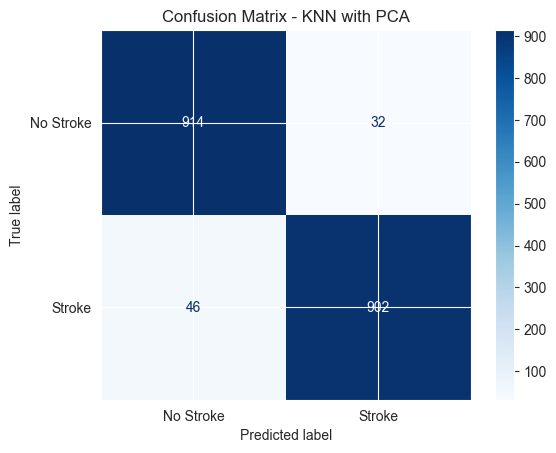

In [151]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

X = df_encoded.drop("stroke", axis=1)
y = df_encoded["stroke"]

smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(X, y)

# 2. Train-test split (using stratification because the classes are imbalanced)
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

# 3. Create a pipeline with scaling, PCA, and KNN classifier
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA()),  # PCA will be tuned for n_components
    ('knn', KNeighborsClassifier())
])

# 4. Determine an approximate number of components to explain 95% of the variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
pca_temp = PCA()
pca_temp.fit(X_train_scaled)
explained_variance = np.cumsum(pca_temp.explained_variance_ratio_)
n_components_95 = np.argmax(explained_variance >= 0.95) + 1
print("Number of PCA components to explain 95% variance:", n_components_95)

# 5. Define a parameter grid for GridSearchCV (tuning PCA n_components and KNN hyperparameters)
param_grid = {
    'pca__n_components': [max(2, n_components_95 - 1), n_components_95, n_components_95 + 1],
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance']
}

# 6. Use GridSearchCV to tune the pipeline based on F1 score
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(x_train, y_train)

print("Best hyperparameters with PCA:", grid_search.best_params_)
print("Best cross-validated F1 score with PCA:", grid_search.best_score_)

# 7. Evaluate the best model on the test set
y_pred = grid_search.predict(x_test)
test_f1 = f1_score(y_test, y_pred)
print("Test F1 score with PCA:", test_f1)

# 8. Plot the confusion matrix for the best PCA model
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["No Stroke", "Stroke"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - KNN with PCA")
plt.show()

Number of PCA components to explain 95% variance: 14

Tuning RandomForest...
RandomForest best CV F1 score: 0.9647
RandomForest Test F1 score: 0.9612
Best parameters: {'model__max_depth': None, 'model__n_estimators': 200, 'pca__n_components': np.int64(15)}

Tuning GradientBoosting...
GradientBoosting best CV F1 score: 0.9637
GradientBoosting Test F1 score: 0.9604
Best parameters: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 200, 'pca__n_components': np.int64(15)}

Tuning Bagging...
Bagging best CV F1 score: 0.9576
Bagging Test F1 score: 0.9544
Best parameters: {'model__n_estimators': 100, 'pca__n_components': np.int64(15)}

Tuning AdaBoost...
AdaBoost best CV F1 score: 0.9347
AdaBoost Test F1 score: 0.9470
Best parameters: {'model__learning_rate': 1.0, 'model__n_estimators': 200, 'pca__n_components': np.int64(15)}

Tuning XGBoost...


/Users/rocker/PycharmProjects/ELG6131/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [22:18:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/rocker/PycharmProjects/ELG6131/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [22:18:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/rocker/PycharmProjects/ELG6131/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [22:18:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/rocker/PycharmProjects/ELG6131/venv/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [22:18:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { 

XGBoost best CV F1 score: 0.9631
XGBoost Test F1 score: 0.9577
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200, 'pca__n_components': np.int64(15)}

Tuning MLP...


/Users/rocker/PycharmProjects/ELG6131/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP best CV F1 score: 0.9576
MLP Test F1 score: 0.9587
Best parameters: {'model__activation': 'relu', 'model__alpha': 0.001, 'model__hidden_layer_sizes': (100,), 'pca__n_components': np.int64(15)}

Summary of Model Performance:
RandomForest: Test F1 = 0.9612, Best CV F1 = 0.9647
GradientBoosting: Test F1 = 0.9604, Best CV F1 = 0.9637
Bagging: Test F1 = 0.9544, Best CV F1 = 0.9576
AdaBoost: Test F1 = 0.9470, Best CV F1 = 0.9347
XGBoost: Test F1 = 0.9577, Best CV F1 = 0.9631
MLP: Test F1 = 0.9587, Best CV F1 = 0.9576

Best Model: RandomForest with Test F1 = 0.9612


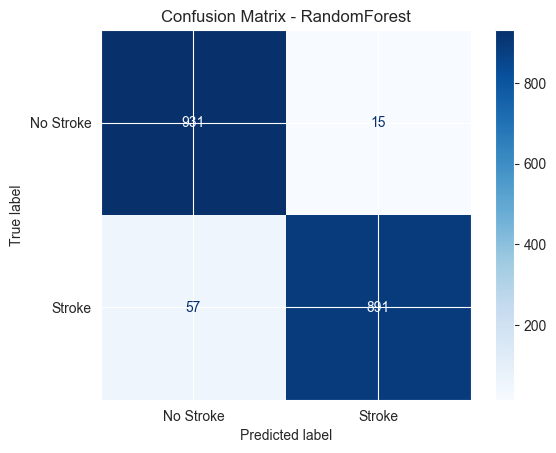

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Classifiers from scikit-learn and xgboost
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# 1. Separate features and target
X = df_encoded.drop("stroke", axis=1)
y = df_encoded["stroke"]

smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(X, y)

# 2. Split the data (using stratification due to class imbalance)
x_train, x_test, y_train, y_test = train_test_split(
    x_resampled, y_resampled, test_size=0.2, random_state=42
)

# 3. Determine number of PCA components to explain ~95% variance using training data
scaler_temp = StandardScaler()
x_train_scaled = scaler_temp.fit_transform(x_train)
pca_temp = PCA()
pca_temp.fit(x_train_scaled)
explained_variance = np.cumsum(pca_temp.explained_variance_ratio_)
n_components_95 = np.argmax(explained_variance >= 0.95) + 1
print("Number of PCA components to explain 95% variance:", n_components_95)

# 4. Create a dictionary of models and corresponding hyperparameter grids.
#    Note: 'pca__n_components' is tuned alongside model hyperparameters.
models = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "param_grid": {
            'pca__n_components': [max(2, n_components_95 - 1), n_components_95, n_components_95 + 1],
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 10, 20]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "param_grid": {
            'pca__n_components': [max(2, n_components_95 - 1), n_components_95, n_components_95 + 1],
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    },
    "Bagging": {
        "model": BaggingClassifier(random_state=42),
        "param_grid": {
            'pca__n_components': [max(2, n_components_95 - 1), n_components_95, n_components_95 + 1],
            'model__n_estimators': [10, 50, 100]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "param_grid": {
            'pca__n_components': [max(2, n_components_95 - 1), n_components_95, n_components_95 + 1],
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 1.0]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "param_grid": {
            'pca__n_components': [max(2, n_components_95 - 1), n_components_95, n_components_95 + 1],
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    },
    "MLP": {
        "model": MLPClassifier(max_iter=1000, random_state=42),
        "param_grid": {
            'pca__n_components': [max(2, n_components_95 - 1), n_components_95, n_components_95 + 1],
            'model__hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'model__alpha': [0.0001, 0.001],
            'model__activation': ['relu', 'tanh']
        }
    }
}

results = {}
best_overall_f1 = 0
best_model_name = None
best_model_pipeline = None

# 5. Loop through each model, perform grid search, and evaluate performance
for model_name, content in models.items():
    print(f"\nTuning {model_name}...")
    # Build a pipeline: scaling -> PCA -> classifier
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('model', content["model"])
    ])
    param_grid = content["param_grid"]

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(x_train, y_train)

    best_params = grid_search.best_params_
    best_cv_f1 = grid_search.best_score_
    y_pred = grid_search.predict(x_test)
    test_f1 = f1_score(y_test, y_pred)

    results[model_name] = {
        "best_params": best_params,
        "best_cv_f1": best_cv_f1,
        "test_f1": test_f1,
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

    print(f"{model_name} best CV F1 score: {best_cv_f1:.4f}")
    print(f"{model_name} Test F1 score: {test_f1:.4f}")
    print("Best parameters:", best_params)

    if test_f1 > best_overall_f1:
        best_overall_f1 = test_f1
        best_model_name = model_name
        best_model_pipeline = grid_search.best_estimator_

# 6. Print a summary of all models' performances
print("\nSummary of Model Performance:")
for model_name, res in results.items():
    print(f"{model_name}: Test F1 = {res['test_f1']:.4f}, Best CV F1 = {res['best_cv_f1']:.4f}")

print(f"\nBest Model: {best_model_name} with Test F1 = {best_overall_f1:.4f}")

# 7. Plot confusion matrix for the best model
disp = ConfusionMatrixDisplay(results[best_model_name]["confusion_matrix"],
                              display_labels=["No Stroke", "Stroke"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

In [16]:
X = df_encoded.drop("stroke", axis=1)
y = df_encoded["stroke"]

smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(X, y)

x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(x_train, y_train)

# Make predictions
y_pred = model.predict(x_test)

# Evaluate the model
print('F1 Score:')
print(f1_score(y_test, y_pred))

F1 Score:
0.9656652360515021


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline  # Pipeline that supports SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from minisom import MiniSom


# Helper: OptionalTransformer
class OptionalTransformer(BaseEstimator, TransformerMixin):
    """
    A wrapper that can skip or apply an underlying transformer based on 'use_transform'.
    """

    def __init__(self, transformer=None, use_transform=True):
        self.transformer = transformer
        self.use_transform = use_transform

    def fit(self, X, y=None):
        if self.use_transform and self.transformer is not None:
            self.transformer.fit(X, y)
        return self

    def transform(self, X):
        if self.use_transform and self.transformer is not None:
            return self.transformer.transform(X)
        return X


# Helper: SOMTransformer
class SOMTransformer(BaseEstimator, TransformerMixin):
    """
    Transforms input features using a Self-Organizing Map (MiniSom).
    Each sample is mapped to the (row, col) coordinates of its best matching unit (BMU).
    """

    def __init__(self, som_x=10, som_y=10, sigma=1.0, learning_rate=0.5, random_seed=42, n_iter=1000):
        self.som_x = som_x
        self.som_y = som_y
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.random_seed = random_seed
        self.n_iter = n_iter

    def fit(self, X, y=None):
        self.som_ = MiniSom(
            x=self.som_x, y=self.som_y, input_len=X.shape[1],
            sigma=self.sigma, learning_rate=self.learning_rate,
            random_seed=self.random_seed
        )
        self.som_.random_weights_init(X)
        self.som_.train_random(X, self.n_iter)
        return self

    def transform(self, X):
        return np.array([self.som_.winner(x) for x in X])

In [ ]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

# -------------------------------
# 3. Define the Pipeline
# -------------------------------
pipeline = Pipeline([
    ('scaler', OptionalTransformer(StandardScaler())),
    ('pca', OptionalTransformer(PCA())),
    ('som', OptionalTransformer(SOMTransformer())),
    ('model', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# -------------------------------
# 4. Define Parameter Grid
#    Toggle use_transform for each step to test all combinations
# -------------------------------
param_grid = {
    'scaler__use_transform': [False, True],
    'pca__use_transform': [False, True],
    'som__use_transform': [False, True],
    'pca__transformer__n_components': [5, 10],
    'som__transformer__som_x': [8, 10],
    'som__transformer__som_y': [8, 10],
    'model__n_estimators': [100, 200, 500, 800],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None]
}

# -------------------------------
# 5. Grid Search Over All Combinations
# -------------------------------
# grid_search = GridSearchCV(
#     pipeline,
#     param_grid,
#     scoring='f1',
#     cv=5,
#     n_jobs=-1
# )
#
# grid_search.fit(x_train, y_train)
#
# print("Best Parameters:", grid_search.best_params_)
# print("Best CV F1 Score:", grid_search.best_score_)

halving_search = HalvingGridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    factor=2,          # how aggressively we "halve"
    cv=5,
    n_jobs=-1,
    random_state=42
)
halving_search.fit(x_train, y_train)

# Evaluate on Test Set
best_model = halving_search.best_estimator_
y_pred = best_model.predict(x_test)
test_f1 = f1_score(y_test, y_pred)
print("Test F1 Score:", test_f1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["No Stroke", "Stroke"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Best Pipeline Combination")
plt.show()

In [21]:
import joblib

rf = RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_estimators=800,
        max_depth=None,
        max_features='sqrt',
        min_samples_leaf=1,
        min_samples_split=2
    )

# 5. Train the Model
rf.fit(x_train, y_train)

# 6. Evaluate on the Test Set
y_pred = rf.predict(x_test)
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_pred))

print('F1 Score:')
print(f1_score(y_test, y_pred))

# 7. Export the Model
joblib.dump(rf, "brain_stroke_model.pkl")
print("Model saved to 'brain_stroke_model.pkl'")

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       946
           1       0.98      0.95      0.97       948

    accuracy                           0.97      1894
   macro avg       0.97      0.97      0.97      1894
weighted avg       0.97      0.97      0.97      1894

Confusion Matrix on Test Set:
[[931  15]
 [ 49 899]]
F1 Score:
0.9656283566058003
Model saved to 'brain_stroke_model.pkl'
